In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
base_path = '../../'
sys.path.append(base_path)

In [3]:


from torch import nn
import torch

"""
3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation
Paper URL: https://arxiv.org/abs/1606.06650
Author: Amir Aghdam
"""

class Conv3DBlock(nn.Module):
    """
    The basic block for double 3x3x3 convolutions in the analysis path
    -- __init__()
    :param in_channels -> number of input channels
    :param out_channels -> desired number of output channels
    :param bottleneck -> specifies the bottlneck block
    -- forward()
    :param input -> input Tensor to be convolved
    :return -> Tensor
    """

    def __init__(self, in_channels, out_channels, bottleneck = False) -> None:
        super(Conv3DBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels= in_channels, out_channels=out_channels//2, kernel_size=(3,3,3), padding=1)
        self.bn1 = nn.BatchNorm3d(num_features=out_channels//2)
        self.conv2 = nn.Conv3d(in_channels= out_channels//2, out_channels=out_channels, kernel_size=(3,3,3), padding=1)
        self.bn2 = nn.BatchNorm3d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.bottleneck = bottleneck
        if not bottleneck:
            self.pooling = nn.MaxPool3d(kernel_size=(2,2,2), stride=2)

    
    def forward(self, input):
        res = self.relu(self.bn1(self.conv1(input)))
        res = self.relu(self.bn2(self.conv2(res)))
        out = None
        if not self.bottleneck:
            out = self.pooling(res)
        else:
            out = res
        return out, res




class UpConv3DBlock(nn.Module):
    """
    The basic block for upsampling followed by double 3x3x3 convolutions in the synthesis path
    -- __init__()
    :param in_channels -> number of input channels
    :param out_channels -> number of residual connections' channels to be concatenated
    :param last_layer -> specifies the last output layer
    :param num_classes -> specifies the number of output channels for dispirate classes
    -- forward()
    :param input -> input Tensor
    :param residual -> residual connection to be concatenated with input
    :return -> Tensor
    """

    def __init__(self, in_channels, res_channels=0, last_layer=False, num_classes=None) -> None:
        super(UpConv3DBlock, self).__init__()
        assert (last_layer==False and num_classes==None) or (last_layer==True and num_classes!=None), 'Invalid arguments'
        self.upconv1 = nn.ConvTranspose3d(in_channels=in_channels, out_channels=in_channels, kernel_size=(2, 2, 2), stride=2)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm3d(num_features=in_channels//2)
        self.conv1 = nn.Conv3d(in_channels=in_channels+res_channels, out_channels=in_channels//2, kernel_size=(3,3,3), padding=(1,1,1))
        self.conv2 = nn.Conv3d(in_channels=in_channels//2, out_channels=in_channels//2, kernel_size=(3,3,3), padding=(1,1,1))
        self.last_layer = last_layer
        if last_layer:
            self.conv3 = nn.Conv3d(in_channels=in_channels//2, out_channels=num_classes, kernel_size=(1,1,1))
            
        
    def forward(self, input, residual=None):
        out = self.upconv1(input)
        if residual!=None: out = torch.cat((out, residual), 1)
        out = self.relu(self.bn(self.conv1(out)))
        out = self.relu(self.bn(self.conv2(out)))
        if self.last_layer: out = self.conv3(out)
        return out
        



class UNet3D(nn.Module):
    """
    The 3D UNet model
    -- __init__()
    :param in_channels -> number of input channels
    :param num_classes -> specifies the number of output channels or masks for different classes
    :param level_channels -> the number of channels at each level (count top-down)
    :param bottleneck_channel -> the number of bottleneck channels 
    :param device -> the device on which to run the model
    -- forward()
    :param input -> input Tensor
    :return -> Tensor
    """
    
    def __init__(self, in_channels, num_classes, level_channels=[64, 128, 256], bottleneck_channel=512) -> None:
        super(UNet3D, self).__init__()
        level_1_chnls, level_2_chnls, level_3_chnls = level_channels[0], level_channels[1], level_channels[2]
        self.a_block1 = Conv3DBlock(in_channels=in_channels, out_channels=level_1_chnls)
        self.a_block2 = Conv3DBlock(in_channels=level_1_chnls, out_channels=level_2_chnls)
        self.a_block3 = Conv3DBlock(in_channels=level_2_chnls, out_channels=level_3_chnls)
        self.bottleNeck = Conv3DBlock(in_channels=level_3_chnls, out_channels=bottleneck_channel, bottleneck= True)
        self.s_block3 = UpConv3DBlock(in_channels=bottleneck_channel, res_channels=level_3_chnls)
        self.s_block2 = UpConv3DBlock(in_channels=level_3_chnls, res_channels=level_2_chnls)
        self.s_block1 = UpConv3DBlock(in_channels=level_2_chnls, res_channels=level_1_chnls, num_classes=num_classes, last_layer=True)

    
    def forward(self, input):
        #Analysis path forward feed
        out, residual_level1 = self.a_block1(input)
        out, residual_level2 = self.a_block2(out)
        out, residual_level3 = self.a_block3(out)
        out, _ = self.bottleNeck(out)

        #Synthesis path forward feed
        out = self.s_block3(out, residual_level3)
        out = self.s_block2(out, residual_level2)
        out = self.s_block1(out, residual_level1)
        return out
model = UNet3D(in_channels=1, num_classes=5, level_channels=[16, 32, 64], bottleneck_channel=128)

In [4]:
from src.pyvista_flow_field_dataset import PyvistaFlowFieldDataset
from src.voxel_flow_field_dataset import VoxelFlowFieldDataset, VoxelFlowFieldDatasetConfig
ds_pv = PyvistaFlowFieldDataset.load_from_huggingface(num_samples=200)
#ds_voxel = VoxelFlowFieldDataset('datasets/voxels',VoxelFlowFieldDatasetConfig(ds_pv, resolution=(32,16,16)))
ds_voxel = VoxelFlowFieldDataset('datasets/voxels')
ds_voxel.normalize()

Found 333 files in repository 'peteole/CoolMucSmall'.
File 1/400: volume_design_1.cgns already exists. Skipping download.
File 2/400: volume_design_10.cgns already exists. Skipping download.
File 3/400: volume_design_1001.cgns already exists. Skipping download.
File 4/400: volume_design_1002.cgns already exists. Skipping download.
File 5/400: volume_design_1003.cgns already exists. Skipping download.
File 6/400: volume_design_1004.cgns already exists. Skipping download.
File 7/400: volume_design_1005.cgns already exists. Skipping download.
File 8/400: volume_design_1006.cgns already exists. Skipping download.
File 9/400: volume_design_1007.cgns already exists. Skipping download.
File 10/400: volume_design_1008.cgns already exists. Skipping download.
File 11/400: volume_design_1009.cgns already exists. Skipping download.
File 12/400: volume_design_101.cgns already exists. Skipping download.
File 13/400: volume_design_1010.cgns already exists. Skipping download.
File 14/400: volume_desig

In [5]:

import torch.utils.data as data
dataloader = data.DataLoader(ds_voxel.get_default_loadable_dataset(), batch_size=100, shuffle=True)

In [6]:
import torch.optim as optim
from tqdm import tqdm
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)
criterion = nn.MSELoss()
lr=2e-4
epochs=400
optimizer = optim.Adam(model.parameters(), lr=lr)
losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for x,y in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        x=x.float().unsqueeze(-1)
        x = x.permute(0, 4, 1, 2, 3)  # (N, D, H, W, C) → (N, C, D, H, W)
        y = y.permute(0, 4, 1, 2, 3)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    losses.append(epoch_loss / len(dataloader))
    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(dataloader)}")

Using device: cuda


Epoch 1/400: 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]


Epoch 1, Loss: 5.8634326457977295


Epoch 2/400: 100%|██████████| 2/2 [00:00<00:00, 13.07it/s]


Epoch 2, Loss: 5.647585868835449


Epoch 3/400: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s]


Epoch 3, Loss: 5.577900052070618


Epoch 4/400: 100%|██████████| 2/2 [00:00<00:00, 14.30it/s]


Epoch 4, Loss: 5.413193941116333


Epoch 5/400: 100%|██████████| 2/2 [00:00<00:00, 13.72it/s]


Epoch 5, Loss: 5.3279709815979


Epoch 6/400: 100%|██████████| 2/2 [00:00<00:00, 14.32it/s]


Epoch 6, Loss: 5.1781907081604


Epoch 7/400: 100%|██████████| 2/2 [00:00<00:00, 14.17it/s]


Epoch 7, Loss: 5.071246147155762


Epoch 8/400: 100%|██████████| 2/2 [00:00<00:00, 14.39it/s]


Epoch 8, Loss: 4.936262130737305


Epoch 9/400: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s]


Epoch 9, Loss: 4.8254512548446655


Epoch 10/400: 100%|██████████| 2/2 [00:00<00:00, 14.35it/s]


Epoch 10, Loss: 4.714111924171448


Epoch 11/400: 100%|██████████| 2/2 [00:00<00:00, 14.20it/s]


Epoch 11, Loss: 4.564030647277832


Epoch 12/400: 100%|██████████| 2/2 [00:00<00:00, 12.89it/s]


Epoch 12, Loss: 4.477094650268555


Epoch 13/400: 100%|██████████| 2/2 [00:00<00:00, 13.75it/s]


Epoch 13, Loss: 4.4377840757369995


Epoch 14/400: 100%|██████████| 2/2 [00:00<00:00, 14.36it/s]


Epoch 14, Loss: 4.282899379730225


Epoch 15/400: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s]


Epoch 15, Loss: 4.273793339729309


Epoch 16/400: 100%|██████████| 2/2 [00:00<00:00, 13.88it/s]


Epoch 16, Loss: 4.193126082420349


Epoch 17/400: 100%|██████████| 2/2 [00:00<00:00, 13.93it/s]


Epoch 17, Loss: 4.0997350215911865


Epoch 18/400: 100%|██████████| 2/2 [00:00<00:00, 14.08it/s]


Epoch 18, Loss: 4.052021384239197


Epoch 19/400: 100%|██████████| 2/2 [00:00<00:00, 14.34it/s]


Epoch 19, Loss: 3.964614987373352


Epoch 20/400: 100%|██████████| 2/2 [00:00<00:00, 14.15it/s]


Epoch 20, Loss: 3.9170587062835693


Epoch 21/400: 100%|██████████| 2/2 [00:00<00:00, 14.29it/s]


Epoch 21, Loss: 3.8256367444992065


Epoch 22/400: 100%|██████████| 2/2 [00:00<00:00, 13.65it/s]


Epoch 22, Loss: 3.933758497238159


Epoch 23/400: 100%|██████████| 2/2 [00:00<00:00, 13.75it/s]


Epoch 23, Loss: 3.7252923250198364


Epoch 24/400: 100%|██████████| 2/2 [00:00<00:00, 14.12it/s]


Epoch 24, Loss: 3.6366682052612305


Epoch 25/400: 100%|██████████| 2/2 [00:00<00:00, 13.76it/s]


Epoch 25, Loss: 3.611051321029663


Epoch 26/400: 100%|██████████| 2/2 [00:00<00:00, 14.16it/s]


Epoch 26, Loss: 3.524506688117981


Epoch 27/400: 100%|██████████| 2/2 [00:00<00:00, 14.11it/s]


Epoch 27, Loss: 3.5228219032287598


Epoch 28/400: 100%|██████████| 2/2 [00:00<00:00, 13.76it/s]


Epoch 28, Loss: 3.4281866550445557


Epoch 29/400: 100%|██████████| 2/2 [00:00<00:00, 13.92it/s]


Epoch 29, Loss: 3.421636462211609


Epoch 30/400: 100%|██████████| 2/2 [00:00<00:00, 14.40it/s]


Epoch 30, Loss: 3.359194815158844


Epoch 31/400: 100%|██████████| 2/2 [00:00<00:00, 14.23it/s]


Epoch 31, Loss: 3.4666783809661865


Epoch 32/400: 100%|██████████| 2/2 [00:00<00:00, 14.29it/s]


Epoch 32, Loss: 3.209778904914856


Epoch 33/400: 100%|██████████| 2/2 [00:00<00:00, 14.35it/s]


Epoch 33, Loss: 3.250919818878174


Epoch 34/400: 100%|██████████| 2/2 [00:00<00:00, 14.26it/s]


Epoch 34, Loss: 3.285313308238983


Epoch 35/400: 100%|██████████| 2/2 [00:00<00:00, 14.37it/s]


Epoch 35, Loss: 3.086693048477173


Epoch 36/400: 100%|██████████| 2/2 [00:00<00:00, 14.11it/s]


Epoch 36, Loss: 3.1032453179359436


Epoch 37/400: 100%|██████████| 2/2 [00:00<00:00, 13.73it/s]


Epoch 37, Loss: 3.0078121423721313


Epoch 38/400: 100%|██████████| 2/2 [00:00<00:00, 14.29it/s]


Epoch 38, Loss: 2.9416303634643555


Epoch 39/400: 100%|██████████| 2/2 [00:00<00:00, 13.93it/s]


Epoch 39, Loss: 2.8759138584136963


Epoch 40/400: 100%|██████████| 2/2 [00:00<00:00, 14.41it/s]


Epoch 40, Loss: 2.811571717262268


Epoch 41/400: 100%|██████████| 2/2 [00:00<00:00, 14.20it/s]


Epoch 41, Loss: 2.7749332189559937


Epoch 42/400: 100%|██████████| 2/2 [00:00<00:00, 13.62it/s]


Epoch 42, Loss: 2.7484852075576782


Epoch 43/400: 100%|██████████| 2/2 [00:00<00:00, 13.56it/s]


Epoch 43, Loss: 2.6833879947662354


Epoch 44/400: 100%|██████████| 2/2 [00:00<00:00, 14.30it/s]


Epoch 44, Loss: 2.681881844997406


Epoch 45/400: 100%|██████████| 2/2 [00:00<00:00, 14.38it/s]


Epoch 45, Loss: 2.5864542722702026


Epoch 46/400: 100%|██████████| 2/2 [00:00<00:00, 14.35it/s]


Epoch 46, Loss: 2.5535058975219727


Epoch 47/400: 100%|██████████| 2/2 [00:00<00:00, 14.30it/s]


Epoch 47, Loss: 2.493948459625244


Epoch 48/400: 100%|██████████| 2/2 [00:00<00:00, 14.35it/s]


Epoch 48, Loss: 2.469469428062439


Epoch 49/400: 100%|██████████| 2/2 [00:00<00:00, 14.33it/s]


Epoch 49, Loss: 2.432267904281616


Epoch 50/400: 100%|██████████| 2/2 [00:00<00:00, 13.95it/s]


Epoch 50, Loss: 2.3613423109054565


Epoch 51/400: 100%|██████████| 2/2 [00:00<00:00, 13.99it/s]


Epoch 51, Loss: 2.326366424560547


Epoch 52/400: 100%|██████████| 2/2 [00:00<00:00, 13.90it/s]


Epoch 52, Loss: 2.279201030731201


Epoch 53/400: 100%|██████████| 2/2 [00:00<00:00, 13.09it/s]


Epoch 53, Loss: 2.346722424030304


Epoch 54/400: 100%|██████████| 2/2 [00:00<00:00, 13.96it/s]


Epoch 54, Loss: 2.21042001247406


Epoch 55/400: 100%|██████████| 2/2 [00:00<00:00, 13.95it/s]


Epoch 55, Loss: 2.1684401631355286


Epoch 56/400: 100%|██████████| 2/2 [00:00<00:00, 14.21it/s]


Epoch 56, Loss: 2.145024359226227


Epoch 57/400: 100%|██████████| 2/2 [00:00<00:00, 13.91it/s]


Epoch 57, Loss: 2.4357316195964813


Epoch 58/400: 100%|██████████| 2/2 [00:00<00:00, 13.76it/s]


Epoch 58, Loss: 2.082333266735077


Epoch 59/400: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s]


Epoch 59, Loss: 2.1022494435310364


Epoch 60/400: 100%|██████████| 2/2 [00:00<00:00, 14.28it/s]


Epoch 60, Loss: 2.2288991808891296


Epoch 61/400: 100%|██████████| 2/2 [00:00<00:00, 14.20it/s]


Epoch 61, Loss: 2.220303475856781


Epoch 62/400: 100%|██████████| 2/2 [00:00<00:00, 14.14it/s]


Epoch 62, Loss: 2.0355645418167114


Epoch 63/400: 100%|██████████| 2/2 [00:00<00:00, 14.15it/s]


Epoch 63, Loss: 2.0510875582695007


Epoch 64/400: 100%|██████████| 2/2 [00:00<00:00, 14.20it/s]


Epoch 64, Loss: 1.9370901584625244


Epoch 65/400: 100%|██████████| 2/2 [00:00<00:00, 14.26it/s]


Epoch 65, Loss: 2.1095879673957825


Epoch 66/400: 100%|██████████| 2/2 [00:00<00:00, 13.36it/s]


Epoch 66, Loss: 1.9619273245334625


Epoch 67/400: 100%|██████████| 2/2 [00:00<00:00, 13.28it/s]


Epoch 67, Loss: 1.815913438796997


Epoch 68/400: 100%|██████████| 2/2 [00:00<00:00, 14.02it/s]


Epoch 68, Loss: 1.7734197974205017


Epoch 69/400: 100%|██████████| 2/2 [00:00<00:00, 14.07it/s]


Epoch 69, Loss: 1.7706928849220276


Epoch 70/400: 100%|██████████| 2/2 [00:00<00:00, 13.61it/s]


Epoch 70, Loss: 1.7034547328948975


Epoch 71/400: 100%|██████████| 2/2 [00:00<00:00, 14.04it/s]


Epoch 71, Loss: 1.711505115032196


Epoch 72/400: 100%|██████████| 2/2 [00:00<00:00, 13.23it/s]


Epoch 72, Loss: 1.6640057563781738


Epoch 73/400: 100%|██████████| 2/2 [00:00<00:00, 13.44it/s]


Epoch 73, Loss: 1.7748287916183472


Epoch 74/400: 100%|██████████| 2/2 [00:00<00:00, 14.14it/s]


Epoch 74, Loss: 1.6270076930522919


Epoch 75/400: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s]


Epoch 75, Loss: 1.568972885608673


Epoch 76/400: 100%|██████████| 2/2 [00:00<00:00, 13.74it/s]


Epoch 76, Loss: 1.5653880834579468


Epoch 77/400: 100%|██████████| 2/2 [00:00<00:00, 13.91it/s]


Epoch 77, Loss: 1.5423374474048615


Epoch 78/400: 100%|██████████| 2/2 [00:00<00:00, 14.11it/s]


Epoch 78, Loss: 1.5338137447834015


Epoch 79/400: 100%|██████████| 2/2 [00:00<00:00, 14.28it/s]


Epoch 79, Loss: 1.4449074268341064


Epoch 80/400: 100%|██████████| 2/2 [00:00<00:00, 14.26it/s]


Epoch 80, Loss: 1.6394222378730774


Epoch 81/400: 100%|██████████| 2/2 [00:00<00:00, 14.20it/s]


Epoch 81, Loss: 1.4019102454185486


Epoch 82/400: 100%|██████████| 2/2 [00:00<00:00, 14.05it/s]


Epoch 82, Loss: 1.4883844554424286


Epoch 83/400: 100%|██████████| 2/2 [00:00<00:00, 13.87it/s]


Epoch 83, Loss: 1.5209027528762817


Epoch 84/400: 100%|██████████| 2/2 [00:00<00:00, 13.74it/s]


Epoch 84, Loss: 1.4032078087329865


Epoch 85/400: 100%|██████████| 2/2 [00:00<00:00, 14.31it/s]


Epoch 85, Loss: 1.3036389350891113


Epoch 86/400: 100%|██████████| 2/2 [00:00<00:00, 14.26it/s]


Epoch 86, Loss: 1.4357830584049225


Epoch 87/400: 100%|██████████| 2/2 [00:00<00:00, 14.12it/s]


Epoch 87, Loss: 1.3047651946544647


Epoch 88/400: 100%|██████████| 2/2 [00:00<00:00, 13.28it/s]


Epoch 88, Loss: 1.2528041005134583


Epoch 89/400: 100%|██████████| 2/2 [00:00<00:00, 13.36it/s]


Epoch 89, Loss: 1.3820116519927979


Epoch 90/400: 100%|██████████| 2/2 [00:00<00:00, 14.24it/s]


Epoch 90, Loss: 1.2169302999973297


Epoch 91/400: 100%|██████████| 2/2 [00:00<00:00, 14.21it/s]


Epoch 91, Loss: 1.3148763477802277


Epoch 92/400: 100%|██████████| 2/2 [00:00<00:00, 13.63it/s]


Epoch 92, Loss: 1.1856572329998016


Epoch 93/400: 100%|██████████| 2/2 [00:00<00:00, 14.23it/s]


Epoch 93, Loss: 1.164684385061264


Epoch 94/400: 100%|██████████| 2/2 [00:00<00:00, 14.03it/s]


Epoch 94, Loss: 1.1005090475082397


Epoch 95/400: 100%|██████████| 2/2 [00:00<00:00, 14.15it/s]


Epoch 95, Loss: 1.072042852640152


Epoch 96/400: 100%|██████████| 2/2 [00:00<00:00, 13.57it/s]


Epoch 96, Loss: 1.0494693219661713


Epoch 97/400: 100%|██████████| 2/2 [00:00<00:00, 14.11it/s]


Epoch 97, Loss: 1.0724184811115265


Epoch 98/400: 100%|██████████| 2/2 [00:00<00:00, 14.17it/s]


Epoch 98, Loss: 0.9945884048938751


Epoch 99/400: 100%|██████████| 2/2 [00:00<00:00, 13.64it/s]


Epoch 99, Loss: 0.9997425079345703


Epoch 100/400: 100%|██████████| 2/2 [00:00<00:00, 14.14it/s]


Epoch 100, Loss: 0.9957899153232574


Epoch 101/400: 100%|██████████| 2/2 [00:00<00:00, 14.08it/s]


Epoch 101, Loss: 1.2741132229566574


Epoch 102/400: 100%|██████████| 2/2 [00:00<00:00, 13.81it/s]


Epoch 102, Loss: 1.1211976259946823


Epoch 103/400: 100%|██████████| 2/2 [00:00<00:00, 13.76it/s]


Epoch 103, Loss: 1.0768747925758362


Epoch 104/400: 100%|██████████| 2/2 [00:00<00:00, 12.96it/s]


Epoch 104, Loss: 0.9617483019828796


Epoch 105/400: 100%|██████████| 2/2 [00:00<00:00, 14.22it/s]


Epoch 105, Loss: 0.8834240436553955


Epoch 106/400: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s]


Epoch 106, Loss: 1.0001857578754425


Epoch 107/400: 100%|██████████| 2/2 [00:00<00:00, 14.36it/s]


Epoch 107, Loss: 0.8745767176151276


Epoch 108/400: 100%|██████████| 2/2 [00:00<00:00, 14.08it/s]


Epoch 108, Loss: 1.0901497304439545


Epoch 109/400: 100%|██████████| 2/2 [00:00<00:00, 13.79it/s]


Epoch 109, Loss: 0.8915203511714935


Epoch 110/400: 100%|██████████| 2/2 [00:00<00:00, 14.08it/s]


Epoch 110, Loss: 0.8366982340812683


Epoch 111/400: 100%|██████████| 2/2 [00:00<00:00, 13.47it/s]


Epoch 111, Loss: 0.8069462776184082


Epoch 112/400: 100%|██████████| 2/2 [00:00<00:00, 14.35it/s]


Epoch 112, Loss: 0.800435334444046


Epoch 113/400: 100%|██████████| 2/2 [00:00<00:00, 14.47it/s]


Epoch 113, Loss: 0.8113942444324493


Epoch 114/400: 100%|██████████| 2/2 [00:00<00:00, 14.18it/s]


Epoch 114, Loss: 0.7411124408245087


Epoch 115/400: 100%|██████████| 2/2 [00:00<00:00, 14.22it/s]


Epoch 115, Loss: 0.7638799548149109


Epoch 116/400: 100%|██████████| 2/2 [00:00<00:00, 14.40it/s]


Epoch 116, Loss: 0.7257136404514313


Epoch 117/400: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s]


Epoch 117, Loss: 0.6986551284790039


Epoch 118/400: 100%|██████████| 2/2 [00:00<00:00, 14.17it/s]


Epoch 118, Loss: 0.7308395802974701


Epoch 119/400: 100%|██████████| 2/2 [00:00<00:00, 13.43it/s]


Epoch 119, Loss: 0.648998498916626


Epoch 120/400: 100%|██████████| 2/2 [00:00<00:00, 14.22it/s]


Epoch 120, Loss: 0.6881495267152786


Epoch 121/400: 100%|██████████| 2/2 [00:00<00:00, 14.16it/s]


Epoch 121, Loss: 0.7026728689670563


Epoch 122/400: 100%|██████████| 2/2 [00:00<00:00, 13.96it/s]


Epoch 122, Loss: 0.832415372133255


Epoch 123/400: 100%|██████████| 2/2 [00:00<00:00, 14.46it/s]


Epoch 123, Loss: 0.6345114707946777


Epoch 124/400: 100%|██████████| 2/2 [00:00<00:00, 14.13it/s]


Epoch 124, Loss: 0.6413365602493286


Epoch 125/400: 100%|██████████| 2/2 [00:00<00:00, 14.47it/s]


Epoch 125, Loss: 0.5853451490402222


Epoch 126/400: 100%|██████████| 2/2 [00:00<00:00, 14.41it/s]


Epoch 126, Loss: 0.5943856090307236


Epoch 127/400: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


Epoch 127, Loss: 0.7239265590906143


Epoch 128/400: 100%|██████████| 2/2 [00:00<00:00, 14.53it/s]


Epoch 128, Loss: 0.683300569653511


Epoch 129/400: 100%|██████████| 2/2 [00:00<00:00, 14.47it/s]


Epoch 129, Loss: 0.614027738571167


Epoch 130/400: 100%|██████████| 2/2 [00:00<00:00, 14.48it/s]


Epoch 130, Loss: 0.5868326425552368


Epoch 131/400: 100%|██████████| 2/2 [00:00<00:00, 14.40it/s]


Epoch 131, Loss: 0.7848504334688187


Epoch 132/400: 100%|██████████| 2/2 [00:00<00:00, 13.85it/s]


Epoch 132, Loss: 0.705682098865509


Epoch 133/400: 100%|██████████| 2/2 [00:00<00:00, 14.43it/s]


Epoch 133, Loss: 0.5131391137838364


Epoch 134/400: 100%|██████████| 2/2 [00:00<00:00, 14.39it/s]


Epoch 134, Loss: 0.5322866141796112


Epoch 135/400: 100%|██████████| 2/2 [00:00<00:00, 14.49it/s]


Epoch 135, Loss: 0.5664288848638535


Epoch 136/400: 100%|██████████| 2/2 [00:00<00:00, 14.49it/s]


Epoch 136, Loss: 0.5472482591867447


Epoch 137/400: 100%|██████████| 2/2 [00:00<00:00, 13.83it/s]


Epoch 137, Loss: 0.5554292798042297


Epoch 138/400: 100%|██████████| 2/2 [00:00<00:00, 14.51it/s]


Epoch 138, Loss: 0.4923197329044342


Epoch 139/400: 100%|██████████| 2/2 [00:00<00:00, 14.35it/s]


Epoch 139, Loss: 0.919651985168457


Epoch 140/400: 100%|██████████| 2/2 [00:00<00:00, 13.96it/s]


Epoch 140, Loss: 0.5404879152774811


Epoch 141/400: 100%|██████████| 2/2 [00:00<00:00, 14.32it/s]


Epoch 141, Loss: 0.6138311922550201


Epoch 142/400: 100%|██████████| 2/2 [00:00<00:00, 14.15it/s]


Epoch 142, Loss: 0.8228708505630493


Epoch 143/400: 100%|██████████| 2/2 [00:00<00:00, 13.49it/s]


Epoch 143, Loss: 0.5161607265472412


Epoch 144/400: 100%|██████████| 2/2 [00:00<00:00, 13.78it/s]


Epoch 144, Loss: 0.5682820230722427


Epoch 145/400: 100%|██████████| 2/2 [00:00<00:00, 13.98it/s]


Epoch 145, Loss: 0.9053438007831573


Epoch 146/400: 100%|██████████| 2/2 [00:00<00:00, 13.04it/s]


Epoch 146, Loss: 0.44959089159965515


Epoch 147/400: 100%|██████████| 2/2 [00:00<00:00, 13.72it/s]


Epoch 147, Loss: 0.5505230724811554


Epoch 148/400: 100%|██████████| 2/2 [00:00<00:00, 14.28it/s]


Epoch 148, Loss: 0.5122217535972595


Epoch 149/400: 100%|██████████| 2/2 [00:00<00:00, 14.11it/s]


Epoch 149, Loss: 0.5020023286342621


Epoch 150/400: 100%|██████████| 2/2 [00:00<00:00, 14.29it/s]


Epoch 150, Loss: 0.6240411102771759


Epoch 151/400: 100%|██████████| 2/2 [00:00<00:00, 13.52it/s]


Epoch 151, Loss: 0.49711261689662933


Epoch 152/400: 100%|██████████| 2/2 [00:00<00:00, 14.13it/s]


Epoch 152, Loss: 0.6152874678373337


Epoch 153/400: 100%|██████████| 2/2 [00:00<00:00, 13.94it/s]


Epoch 153, Loss: 0.7819686830043793


Epoch 154/400: 100%|██████████| 2/2 [00:00<00:00, 13.72it/s]


Epoch 154, Loss: 0.459313228726387


Epoch 155/400: 100%|██████████| 2/2 [00:00<00:00, 14.33it/s]


Epoch 155, Loss: 0.5314646810293198


Epoch 156/400: 100%|██████████| 2/2 [00:00<00:00, 13.93it/s]


Epoch 156, Loss: 0.44737571477890015


Epoch 157/400: 100%|██████████| 2/2 [00:00<00:00, 14.14it/s]


Epoch 157, Loss: 0.4291144460439682


Epoch 158/400: 100%|██████████| 2/2 [00:00<00:00, 14.11it/s]


Epoch 158, Loss: 0.42089955508708954


Epoch 159/400: 100%|██████████| 2/2 [00:00<00:00, 14.15it/s]


Epoch 159, Loss: 0.48946578800678253


Epoch 160/400: 100%|██████████| 2/2 [00:00<00:00, 14.33it/s]


Epoch 160, Loss: 0.702248141169548


Epoch 161/400: 100%|██████████| 2/2 [00:00<00:00, 12.71it/s]


Epoch 161, Loss: 0.4412173330783844


Epoch 162/400: 100%|██████████| 2/2 [00:00<00:00, 14.25it/s]


Epoch 162, Loss: 0.3882819712162018


Epoch 163/400: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s]


Epoch 163, Loss: 0.36506710946559906


Epoch 164/400: 100%|██████████| 2/2 [00:00<00:00, 14.41it/s]


Epoch 164, Loss: 0.3585292547941208


Epoch 165/400: 100%|██████████| 2/2 [00:00<00:00, 14.42it/s]


Epoch 165, Loss: 0.38527558743953705


Epoch 166/400: 100%|██████████| 2/2 [00:00<00:00, 13.93it/s]


Epoch 166, Loss: 0.4055968075990677


Epoch 167/400: 100%|██████████| 2/2 [00:00<00:00, 13.98it/s]


Epoch 167, Loss: 0.6489870250225067


Epoch 168/400: 100%|██████████| 2/2 [00:00<00:00, 13.80it/s]


Epoch 168, Loss: 0.3909251242876053


Epoch 169/400: 100%|██████████| 2/2 [00:00<00:00, 13.96it/s]


Epoch 169, Loss: 0.37247511744499207


Epoch 170/400: 100%|██████████| 2/2 [00:00<00:00, 14.21it/s]


Epoch 170, Loss: 0.36477309465408325


Epoch 171/400: 100%|██████████| 2/2 [00:00<00:00, 14.35it/s]


Epoch 171, Loss: 1.0119673311710358


Epoch 172/400: 100%|██████████| 2/2 [00:00<00:00, 14.05it/s]


Epoch 172, Loss: 0.3594009727239609


Epoch 173/400: 100%|██████████| 2/2 [00:00<00:00, 14.34it/s]


Epoch 173, Loss: 0.6348440647125244


Epoch 174/400: 100%|██████████| 2/2 [00:00<00:00, 13.72it/s]


Epoch 174, Loss: 0.4807695150375366


Epoch 175/400: 100%|██████████| 2/2 [00:00<00:00, 13.41it/s]


Epoch 175, Loss: 0.4574197232723236


Epoch 176/400: 100%|██████████| 2/2 [00:00<00:00, 14.24it/s]


Epoch 176, Loss: 0.43907612562179565


Epoch 177/400: 100%|██████████| 2/2 [00:00<00:00, 14.06it/s]


Epoch 177, Loss: 1.183396339416504


Epoch 178/400: 100%|██████████| 2/2 [00:00<00:00, 14.16it/s]


Epoch 178, Loss: 0.3883717656135559


Epoch 179/400: 100%|██████████| 2/2 [00:00<00:00, 14.25it/s]


Epoch 179, Loss: 0.4568989872932434


Epoch 180/400: 100%|██████████| 2/2 [00:00<00:00, 13.63it/s]


Epoch 180, Loss: 0.45204098522663116


Epoch 181/400: 100%|██████████| 2/2 [00:00<00:00, 14.10it/s]


Epoch 181, Loss: 0.567850187420845


Epoch 182/400: 100%|██████████| 2/2 [00:00<00:00, 14.16it/s]


Epoch 182, Loss: 0.4709709882736206


Epoch 183/400: 100%|██████████| 2/2 [00:00<00:00, 14.11it/s]


Epoch 183, Loss: 0.929961621761322


Epoch 184/400: 100%|██████████| 2/2 [00:00<00:00, 14.29it/s]


Epoch 184, Loss: 0.42787063121795654


Epoch 185/400: 100%|██████████| 2/2 [00:00<00:00, 14.20it/s]


Epoch 185, Loss: 0.4306657612323761


Epoch 186/400: 100%|██████████| 2/2 [00:00<00:00, 14.05it/s]


Epoch 186, Loss: 0.3783266395330429


Epoch 187/400: 100%|██████████| 2/2 [00:00<00:00, 13.72it/s]


Epoch 187, Loss: 0.3827415406703949


Epoch 188/400: 100%|██████████| 2/2 [00:00<00:00, 13.83it/s]


Epoch 188, Loss: 0.3967592269182205


Epoch 189/400: 100%|██████████| 2/2 [00:00<00:00, 13.97it/s]


Epoch 189, Loss: 0.422047957777977


Epoch 190/400: 100%|██████████| 2/2 [00:00<00:00, 13.67it/s]


Epoch 190, Loss: 0.37773333489894867


Epoch 191/400: 100%|██████████| 2/2 [00:00<00:00, 14.14it/s]


Epoch 191, Loss: 0.9030196964740753


Epoch 192/400: 100%|██████████| 2/2 [00:00<00:00, 13.89it/s]


Epoch 192, Loss: 0.31949861347675323


Epoch 193/400: 100%|██████████| 2/2 [00:00<00:00, 13.65it/s]


Epoch 193, Loss: 0.30818168818950653


Epoch 194/400: 100%|██████████| 2/2 [00:00<00:00, 14.39it/s]


Epoch 194, Loss: 0.7101034224033356


Epoch 195/400: 100%|██████████| 2/2 [00:00<00:00, 14.21it/s]


Epoch 195, Loss: 0.30067404359579086


Epoch 196/400: 100%|██████████| 2/2 [00:00<00:00, 14.40it/s]


Epoch 196, Loss: 0.6232890784740448


Epoch 197/400: 100%|██████████| 2/2 [00:00<00:00, 14.17it/s]


Epoch 197, Loss: 0.3539177179336548


Epoch 198/400: 100%|██████████| 2/2 [00:00<00:00, 14.15it/s]


Epoch 198, Loss: 0.2884255424141884


Epoch 199/400: 100%|██████████| 2/2 [00:00<00:00, 13.77it/s]


Epoch 199, Loss: 0.2910226285457611


Epoch 200/400: 100%|██████████| 2/2 [00:00<00:00, 12.85it/s]


Epoch 200, Loss: 0.42440153658390045


Epoch 201/400: 100%|██████████| 2/2 [00:00<00:00, 14.25it/s]


Epoch 201, Loss: 0.2877395376563072


Epoch 202/400: 100%|██████████| 2/2 [00:00<00:00, 14.23it/s]


Epoch 202, Loss: 0.3207763135433197


Epoch 203/400: 100%|██████████| 2/2 [00:00<00:00, 14.04it/s]


Epoch 203, Loss: 0.2905358076095581


Epoch 204/400: 100%|██████████| 2/2 [00:00<00:00, 14.14it/s]


Epoch 204, Loss: 0.2849612385034561


Epoch 205/400: 100%|██████████| 2/2 [00:00<00:00, 14.36it/s]


Epoch 205, Loss: 0.36203841865062714


Epoch 206/400: 100%|██████████| 2/2 [00:00<00:00, 14.31it/s]


Epoch 206, Loss: 0.25443872809410095


Epoch 207/400: 100%|██████████| 2/2 [00:00<00:00, 14.25it/s]


Epoch 207, Loss: 0.41560840606689453


Epoch 208/400: 100%|██████████| 2/2 [00:00<00:00, 13.90it/s]


Epoch 208, Loss: 0.3037664592266083


Epoch 209/400: 100%|██████████| 2/2 [00:00<00:00, 14.26it/s]


Epoch 209, Loss: 0.253834530711174


Epoch 210/400: 100%|██████████| 2/2 [00:00<00:00, 14.07it/s]


Epoch 210, Loss: 0.2389550432562828


Epoch 211/400: 100%|██████████| 2/2 [00:00<00:00, 14.11it/s]


Epoch 211, Loss: 0.28650525212287903


Epoch 212/400: 100%|██████████| 2/2 [00:00<00:00, 13.89it/s]


Epoch 212, Loss: 0.251625120639801


Epoch 213/400: 100%|██████████| 2/2 [00:00<00:00, 14.02it/s]


Epoch 213, Loss: 0.2792855352163315


Epoch 214/400: 100%|██████████| 2/2 [00:00<00:00, 11.25it/s]


Epoch 214, Loss: 0.44938699901103973


Epoch 215/400: 100%|██████████| 2/2 [00:00<00:00, 13.67it/s]


Epoch 215, Loss: 0.2494865581393242


Epoch 216/400: 100%|██████████| 2/2 [00:00<00:00, 14.15it/s]


Epoch 216, Loss: 0.28640570491552353


Epoch 217/400: 100%|██████████| 2/2 [00:00<00:00, 14.26it/s]


Epoch 217, Loss: 0.2597758024930954


Epoch 218/400: 100%|██████████| 2/2 [00:00<00:00, 13.91it/s]


Epoch 218, Loss: 0.3891688585281372


Epoch 219/400: 100%|██████████| 2/2 [00:00<00:00, 14.05it/s]


Epoch 219, Loss: 0.24744822829961777


Epoch 220/400: 100%|██████████| 2/2 [00:00<00:00, 13.58it/s]


Epoch 220, Loss: 0.36609770357608795


Epoch 221/400: 100%|██████████| 2/2 [00:00<00:00, 14.30it/s]


Epoch 221, Loss: 0.3484014421701431


Epoch 222/400: 100%|██████████| 2/2 [00:00<00:00, 14.13it/s]


Epoch 222, Loss: 0.31573867052793503


Epoch 223/400: 100%|██████████| 2/2 [00:00<00:00, 12.89it/s]


Epoch 223, Loss: 0.25901903957128525


Epoch 224/400: 100%|██████████| 2/2 [00:00<00:00, 14.05it/s]


Epoch 224, Loss: 0.3715045601129532


Epoch 225/400: 100%|██████████| 2/2 [00:00<00:00, 14.22it/s]


Epoch 225, Loss: 0.27758806198835373


Epoch 226/400: 100%|██████████| 2/2 [00:00<00:00, 14.17it/s]


Epoch 226, Loss: 0.6220768094062805


Epoch 227/400: 100%|██████████| 2/2 [00:00<00:00, 14.09it/s]


Epoch 227, Loss: 0.25755805522203445


Epoch 228/400: 100%|██████████| 2/2 [00:00<00:00, 13.91it/s]


Epoch 228, Loss: 0.2673252671957016


Epoch 229/400: 100%|██████████| 2/2 [00:00<00:00, 14.05it/s]


Epoch 229, Loss: 0.31839026510715485


Epoch 230/400: 100%|██████████| 2/2 [00:00<00:00, 13.66it/s]


Epoch 230, Loss: 0.43618081510066986


Epoch 231/400: 100%|██████████| 2/2 [00:00<00:00, 13.45it/s]


Epoch 231, Loss: 0.4329734891653061


Epoch 232/400: 100%|██████████| 2/2 [00:00<00:00, 14.06it/s]


Epoch 232, Loss: 0.26931503415107727


Epoch 233/400: 100%|██████████| 2/2 [00:00<00:00, 13.92it/s]


Epoch 233, Loss: 1.0388811528682709


Epoch 234/400: 100%|██████████| 2/2 [00:00<00:00, 14.03it/s]


Epoch 234, Loss: 0.3060487285256386


Epoch 235/400: 100%|██████████| 2/2 [00:00<00:00, 14.32it/s]


Epoch 235, Loss: 0.41608770191669464


Epoch 236/400: 100%|██████████| 2/2 [00:00<00:00, 13.13it/s]


Epoch 236, Loss: 0.2889602482318878


Epoch 237/400: 100%|██████████| 2/2 [00:00<00:00, 13.73it/s]


Epoch 237, Loss: 0.5927734076976776


Epoch 238/400: 100%|██████████| 2/2 [00:00<00:00, 13.79it/s]


Epoch 238, Loss: 0.34250278770923615


Epoch 239/400: 100%|██████████| 2/2 [00:00<00:00, 13.51it/s]


Epoch 239, Loss: 0.36431196331977844


Epoch 240/400: 100%|██████████| 2/2 [00:00<00:00, 13.51it/s]


Epoch 240, Loss: 0.2659911587834358


Epoch 241/400: 100%|██████████| 2/2 [00:00<00:00, 14.02it/s]


Epoch 241, Loss: 0.2775207534432411


Epoch 242/400: 100%|██████████| 2/2 [00:00<00:00, 13.83it/s]


Epoch 242, Loss: 0.3503127098083496


Epoch 243/400: 100%|██████████| 2/2 [00:00<00:00, 14.07it/s]


Epoch 243, Loss: 0.5553902089595795


Epoch 244/400: 100%|██████████| 2/2 [00:00<00:00, 13.08it/s]


Epoch 244, Loss: 2.12948876619339


Epoch 245/400: 100%|██████████| 2/2 [00:00<00:00, 14.28it/s]


Epoch 245, Loss: 0.32495103776454926


Epoch 246/400: 100%|██████████| 2/2 [00:00<00:00, 13.48it/s]


Epoch 246, Loss: 0.33076831698417664


Epoch 247/400: 100%|██████████| 2/2 [00:00<00:00, 13.82it/s]


Epoch 247, Loss: 0.3960018903017044


Epoch 248/400: 100%|██████████| 2/2 [00:00<00:00, 14.06it/s]


Epoch 248, Loss: 0.33599504828453064


Epoch 249/400: 100%|██████████| 2/2 [00:00<00:00, 14.05it/s]


Epoch 249, Loss: 0.4659980982542038


Epoch 250/400: 100%|██████████| 2/2 [00:00<00:00, 13.54it/s]


Epoch 250, Loss: 0.3389985263347626


Epoch 251/400: 100%|██████████| 2/2 [00:00<00:00, 14.15it/s]


Epoch 251, Loss: 1.364167332649231


Epoch 252/400: 100%|██████████| 2/2 [00:00<00:00, 14.16it/s]


Epoch 252, Loss: 0.37274228036403656


Epoch 253/400: 100%|██████████| 2/2 [00:00<00:00, 14.23it/s]


Epoch 253, Loss: 0.32915762066841125


Epoch 254/400: 100%|██████████| 2/2 [00:00<00:00, 14.22it/s]


Epoch 254, Loss: 0.34135015308856964


Epoch 255/400: 100%|██████████| 2/2 [00:00<00:00, 13.91it/s]


Epoch 255, Loss: 0.31011223793029785


Epoch 256/400: 100%|██████████| 2/2 [00:00<00:00, 14.24it/s]


Epoch 256, Loss: 0.3231164664030075


Epoch 257/400: 100%|██████████| 2/2 [00:00<00:00, 14.32it/s]


Epoch 257, Loss: 0.2691460996866226


Epoch 258/400: 100%|██████████| 2/2 [00:00<00:00, 12.95it/s]


Epoch 258, Loss: 1.016193449497223


Epoch 259/400: 100%|██████████| 2/2 [00:00<00:00, 14.22it/s]


Epoch 259, Loss: 0.289692759513855


Epoch 260/400: 100%|██████████| 2/2 [00:00<00:00, 13.87it/s]


Epoch 260, Loss: 0.31313835084438324


Epoch 261/400: 100%|██████████| 2/2 [00:00<00:00, 14.02it/s]


Epoch 261, Loss: 0.6567239463329315


Epoch 262/400: 100%|██████████| 2/2 [00:00<00:00, 13.76it/s]


Epoch 262, Loss: 0.3007565289735794


Epoch 263/400: 100%|██████████| 2/2 [00:00<00:00, 13.99it/s]


Epoch 263, Loss: 0.3372005522251129


Epoch 264/400: 100%|██████████| 2/2 [00:00<00:00, 13.28it/s]


Epoch 264, Loss: 0.39741891622543335


Epoch 265/400: 100%|██████████| 2/2 [00:00<00:00, 13.88it/s]


Epoch 265, Loss: 0.4299185276031494


Epoch 266/400: 100%|██████████| 2/2 [00:00<00:00, 14.01it/s]


Epoch 266, Loss: 0.24049324542284012


Epoch 267/400: 100%|██████████| 2/2 [00:00<00:00, 14.30it/s]


Epoch 267, Loss: 0.36640509963035583


Epoch 268/400: 100%|██████████| 2/2 [00:00<00:00, 14.31it/s]


Epoch 268, Loss: 0.24736453592777252


Epoch 269/400: 100%|██████████| 2/2 [00:00<00:00, 13.83it/s]


Epoch 269, Loss: 0.28762729465961456


Epoch 270/400: 100%|██████████| 2/2 [00:00<00:00, 13.12it/s]


Epoch 270, Loss: 0.27752336859703064


Epoch 271/400: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s]


Epoch 271, Loss: 0.22692690789699554


Epoch 272/400: 100%|██████████| 2/2 [00:00<00:00, 13.91it/s]


Epoch 272, Loss: 0.480952188372612


Epoch 273/400: 100%|██████████| 2/2 [00:00<00:00, 13.78it/s]


Epoch 273, Loss: 0.9190854728221893


Epoch 274/400: 100%|██████████| 2/2 [00:00<00:00, 14.12it/s]


Epoch 274, Loss: 0.22539161145687103


Epoch 275/400: 100%|██████████| 2/2 [00:00<00:00, 13.43it/s]


Epoch 275, Loss: 0.38741634786129


Epoch 276/400: 100%|██████████| 2/2 [00:00<00:00, 13.42it/s]


Epoch 276, Loss: 0.20825818181037903


Epoch 277/400: 100%|██████████| 2/2 [00:00<00:00, 14.03it/s]


Epoch 277, Loss: 0.2072548344731331


Epoch 278/400: 100%|██████████| 2/2 [00:00<00:00, 13.52it/s]


Epoch 278, Loss: 0.21667473018169403


Epoch 279/400: 100%|██████████| 2/2 [00:00<00:00, 14.28it/s]


Epoch 279, Loss: 0.6961355209350586


Epoch 280/400: 100%|██████████| 2/2 [00:00<00:00, 14.40it/s]


Epoch 280, Loss: 0.21140612661838531


Epoch 281/400: 100%|██████████| 2/2 [00:00<00:00, 14.26it/s]


Epoch 281, Loss: 0.3411230742931366


Epoch 282/400: 100%|██████████| 2/2 [00:00<00:00, 14.30it/s]


Epoch 282, Loss: 0.20436177402734756


Epoch 283/400: 100%|██████████| 2/2 [00:00<00:00, 14.20it/s]


Epoch 283, Loss: 0.33310045301914215


Epoch 284/400: 100%|██████████| 2/2 [00:00<00:00, 14.08it/s]


Epoch 284, Loss: 0.20367373526096344


Epoch 285/400: 100%|██████████| 2/2 [00:00<00:00, 14.28it/s]


Epoch 285, Loss: 0.19748665392398834


Epoch 286/400: 100%|██████████| 2/2 [00:00<00:00, 13.94it/s]


Epoch 286, Loss: 0.29388561844825745


Epoch 287/400: 100%|██████████| 2/2 [00:00<00:00, 13.59it/s]


Epoch 287, Loss: 0.47366756200790405


Epoch 288/400: 100%|██████████| 2/2 [00:00<00:00, 14.12it/s]


Epoch 288, Loss: 0.2200949490070343


Epoch 289/400: 100%|██████████| 2/2 [00:00<00:00, 14.11it/s]


Epoch 289, Loss: 0.19955241680145264


Epoch 290/400: 100%|██████████| 2/2 [00:00<00:00, 12.60it/s]


Epoch 290, Loss: 0.2992120385169983


Epoch 291/400: 100%|██████████| 2/2 [00:00<00:00, 13.95it/s]


Epoch 291, Loss: 0.32938458025455475


Epoch 292/400: 100%|██████████| 2/2 [00:00<00:00, 13.77it/s]


Epoch 292, Loss: 0.20377704501152039


Epoch 293/400: 100%|██████████| 2/2 [00:00<00:00, 13.29it/s]


Epoch 293, Loss: 0.21804986149072647


Epoch 294/400: 100%|██████████| 2/2 [00:00<00:00, 13.65it/s]


Epoch 294, Loss: 0.21009158343076706


Epoch 295/400: 100%|██████████| 2/2 [00:00<00:00, 14.12it/s]


Epoch 295, Loss: 0.19383807107806206


Epoch 296/400: 100%|██████████| 2/2 [00:00<00:00, 12.91it/s]


Epoch 296, Loss: 0.19995124638080597


Epoch 297/400: 100%|██████████| 2/2 [00:00<00:00, 13.80it/s]


Epoch 297, Loss: 0.19525505974888802


Epoch 298/400: 100%|██████████| 2/2 [00:00<00:00, 14.30it/s]


Epoch 298, Loss: 0.2233670875430107


Epoch 299/400: 100%|██████████| 2/2 [00:00<00:00, 14.31it/s]


Epoch 299, Loss: 0.2883538156747818


Epoch 300/400: 100%|██████████| 2/2 [00:00<00:00, 14.21it/s]


Epoch 300, Loss: 0.292199045419693


Epoch 301/400: 100%|██████████| 2/2 [00:00<00:00, 14.27it/s]


Epoch 301, Loss: 0.19151155650615692


Epoch 302/400: 100%|██████████| 2/2 [00:00<00:00, 13.86it/s]


Epoch 302, Loss: 0.36071574687957764


Epoch 303/400: 100%|██████████| 2/2 [00:00<00:00, 14.22it/s]


Epoch 303, Loss: 0.36260390281677246


Epoch 304/400: 100%|██████████| 2/2 [00:00<00:00, 14.01it/s]


Epoch 304, Loss: 0.18097255378961563


Epoch 305/400: 100%|██████████| 2/2 [00:00<00:00, 14.16it/s]


Epoch 305, Loss: 0.23113314807415009


Epoch 306/400: 100%|██████████| 2/2 [00:00<00:00, 13.79it/s]


Epoch 306, Loss: 0.17853721976280212


Epoch 307/400: 100%|██████████| 2/2 [00:00<00:00, 14.34it/s]


Epoch 307, Loss: 0.17152813076972961


Epoch 308/400: 100%|██████████| 2/2 [00:00<00:00, 14.26it/s]


Epoch 308, Loss: 0.20209971070289612


Epoch 309/400: 100%|██████████| 2/2 [00:00<00:00, 14.22it/s]


Epoch 309, Loss: 0.5241807401180267


Epoch 310/400: 100%|██████████| 2/2 [00:00<00:00, 14.16it/s]


Epoch 310, Loss: 0.247320719063282


Epoch 311/400: 100%|██████████| 2/2 [00:00<00:00, 13.47it/s]


Epoch 311, Loss: 0.2203729823231697


Epoch 312/400: 100%|██████████| 2/2 [00:00<00:00, 14.05it/s]


Epoch 312, Loss: 0.2379077970981598


Epoch 313/400: 100%|██████████| 2/2 [00:00<00:00, 13.79it/s]


Epoch 313, Loss: 0.2250853218138218


Epoch 314/400: 100%|██████████| 2/2 [00:00<00:00, 13.67it/s]


Epoch 314, Loss: 0.41667358577251434


Epoch 315/400: 100%|██████████| 2/2 [00:00<00:00, 14.24it/s]


Epoch 315, Loss: 0.1820691153407097


Epoch 316/400: 100%|██████████| 2/2 [00:00<00:00, 14.28it/s]


Epoch 316, Loss: 0.1839817799627781


Epoch 317/400: 100%|██████████| 2/2 [00:00<00:00, 14.18it/s]


Epoch 317, Loss: 0.20571214705705643


Epoch 318/400: 100%|██████████| 2/2 [00:00<00:00, 13.98it/s]


Epoch 318, Loss: 0.24798722565174103


Epoch 319/400: 100%|██████████| 2/2 [00:00<00:00, 14.28it/s]


Epoch 319, Loss: 0.31578847765922546


Epoch 320/400: 100%|██████████| 2/2 [00:00<00:00, 14.30it/s]


Epoch 320, Loss: 0.1687043532729149


Epoch 321/400: 100%|██████████| 2/2 [00:00<00:00, 14.09it/s]


Epoch 321, Loss: 0.15550526231527328


Epoch 322/400: 100%|██████████| 2/2 [00:00<00:00, 13.87it/s]


Epoch 322, Loss: 0.32613392174243927


Epoch 323/400: 100%|██████████| 2/2 [00:00<00:00, 14.22it/s]


Epoch 323, Loss: 0.27827710658311844


Epoch 324/400: 100%|██████████| 2/2 [00:00<00:00, 13.23it/s]


Epoch 324, Loss: 0.206444900482893


Epoch 325/400: 100%|██████████| 2/2 [00:00<00:00, 14.18it/s]


Epoch 325, Loss: 0.3269047439098358


Epoch 326/400: 100%|██████████| 2/2 [00:00<00:00, 13.99it/s]


Epoch 326, Loss: 0.3391876220703125


Epoch 327/400: 100%|██████████| 2/2 [00:00<00:00, 13.64it/s]


Epoch 327, Loss: 0.18227408081293106


Epoch 328/400: 100%|██████████| 2/2 [00:00<00:00, 14.23it/s]


Epoch 328, Loss: 0.18497206270694733


Epoch 329/400: 100%|██████████| 2/2 [00:00<00:00, 13.48it/s]


Epoch 329, Loss: 0.31520912051200867


Epoch 330/400: 100%|██████████| 2/2 [00:00<00:00, 14.17it/s]


Epoch 330, Loss: 0.2565826326608658


Epoch 331/400: 100%|██████████| 2/2 [00:00<00:00, 14.32it/s]


Epoch 331, Loss: 0.15617629140615463


Epoch 332/400: 100%|██████████| 2/2 [00:00<00:00, 14.24it/s]


Epoch 332, Loss: 0.18018532544374466


Epoch 333/400: 100%|██████████| 2/2 [00:00<00:00, 14.37it/s]


Epoch 333, Loss: 0.4726526439189911


Epoch 334/400: 100%|██████████| 2/2 [00:00<00:00, 14.33it/s]


Epoch 334, Loss: 0.21001655235886574


Epoch 335/400: 100%|██████████| 2/2 [00:00<00:00, 13.97it/s]


Epoch 335, Loss: 0.1696706786751747


Epoch 336/400: 100%|██████████| 2/2 [00:00<00:00, 14.21it/s]


Epoch 336, Loss: 0.19988935813307762


Epoch 337/400: 100%|██████████| 2/2 [00:00<00:00, 14.25it/s]


Epoch 337, Loss: 0.19961994886398315


Epoch 338/400: 100%|██████████| 2/2 [00:00<00:00, 14.22it/s]


Epoch 338, Loss: 0.16961683705449104


Epoch 339/400: 100%|██████████| 2/2 [00:00<00:00, 13.96it/s]


Epoch 339, Loss: 0.20082517713308334


Epoch 340/400: 100%|██████████| 2/2 [00:00<00:00, 14.35it/s]


Epoch 340, Loss: 0.4668659418821335


Epoch 341/400: 100%|██████████| 2/2 [00:00<00:00, 14.24it/s]


Epoch 341, Loss: 0.1525188609957695


Epoch 342/400: 100%|██████████| 2/2 [00:00<00:00, 14.07it/s]


Epoch 342, Loss: 0.4728757292032242


Epoch 343/400: 100%|██████████| 2/2 [00:00<00:00, 14.22it/s]


Epoch 343, Loss: 0.251436211168766


Epoch 344/400: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s]


Epoch 344, Loss: 0.20441880822181702


Epoch 345/400: 100%|██████████| 2/2 [00:00<00:00, 13.57it/s]


Epoch 345, Loss: 0.7956804931163788


Epoch 346/400: 100%|██████████| 2/2 [00:00<00:00, 13.53it/s]


Epoch 346, Loss: 0.40764471888542175


Epoch 347/400: 100%|██████████| 2/2 [00:00<00:00, 14.11it/s]


Epoch 347, Loss: 0.193398579955101


Epoch 348/400: 100%|██████████| 2/2 [00:00<00:00, 13.87it/s]


Epoch 348, Loss: 0.17466871440410614


Epoch 349/400: 100%|██████████| 2/2 [00:00<00:00, 14.20it/s]


Epoch 349, Loss: 0.9413329362869263


Epoch 350/400: 100%|██████████| 2/2 [00:00<00:00, 14.20it/s]


Epoch 350, Loss: 0.22302131354808807


Epoch 351/400: 100%|██████████| 2/2 [00:00<00:00, 14.23it/s]


Epoch 351, Loss: 0.5690841674804688


Epoch 352/400: 100%|██████████| 2/2 [00:00<00:00, 14.18it/s]


Epoch 352, Loss: 0.6673963367938995


Epoch 353/400: 100%|██████████| 2/2 [00:00<00:00, 13.45it/s]


Epoch 353, Loss: 0.3174758106470108


Epoch 354/400: 100%|██████████| 2/2 [00:00<00:00, 14.22it/s]


Epoch 354, Loss: 0.24884764850139618


Epoch 355/400: 100%|██████████| 2/2 [00:00<00:00, 14.36it/s]


Epoch 355, Loss: 0.5871671885251999


Epoch 356/400: 100%|██████████| 2/2 [00:00<00:00, 14.18it/s]


Epoch 356, Loss: 0.20438411831855774


Epoch 357/400: 100%|██████████| 2/2 [00:00<00:00, 14.16it/s]


Epoch 357, Loss: 0.21847279369831085


Epoch 358/400: 100%|██████████| 2/2 [00:00<00:00, 13.92it/s]


Epoch 358, Loss: 0.21047495305538177


Epoch 359/400: 100%|██████████| 2/2 [00:00<00:00, 14.43it/s]


Epoch 359, Loss: 0.18772262334823608


Epoch 360/400: 100%|██████████| 2/2 [00:00<00:00, 14.30it/s]


Epoch 360, Loss: 0.20089899748563766


Epoch 361/400: 100%|██████████| 2/2 [00:00<00:00, 14.35it/s]


Epoch 361, Loss: 0.2597833275794983


Epoch 362/400: 100%|██████████| 2/2 [00:00<00:00, 14.29it/s]


Epoch 362, Loss: 0.16977936774492264


Epoch 363/400: 100%|██████████| 2/2 [00:00<00:00, 14.30it/s]


Epoch 363, Loss: 0.17902758717536926


Epoch 364/400: 100%|██████████| 2/2 [00:00<00:00, 13.74it/s]


Epoch 364, Loss: 0.20083379745483398


Epoch 365/400: 100%|██████████| 2/2 [00:00<00:00, 14.11it/s]


Epoch 365, Loss: 0.18402160704135895


Epoch 366/400: 100%|██████████| 2/2 [00:00<00:00, 13.03it/s]


Epoch 366, Loss: 0.15258286148309708


Epoch 367/400: 100%|██████████| 2/2 [00:00<00:00, 13.62it/s]


Epoch 367, Loss: 0.2086043804883957


Epoch 368/400: 100%|██████████| 2/2 [00:00<00:00, 13.51it/s]


Epoch 368, Loss: 0.16859078779816628


Epoch 369/400: 100%|██████████| 2/2 [00:00<00:00, 14.10it/s]


Epoch 369, Loss: 0.6134912371635437


Epoch 370/400: 100%|██████████| 2/2 [00:00<00:00, 13.62it/s]


Epoch 370, Loss: 0.1564745008945465


Epoch 371/400: 100%|██████████| 2/2 [00:00<00:00, 13.65it/s]


Epoch 371, Loss: 0.7024520039558411


Epoch 372/400: 100%|██████████| 2/2 [00:00<00:00, 14.11it/s]


Epoch 372, Loss: 0.28712308406829834


Epoch 373/400: 100%|██████████| 2/2 [00:00<00:00, 14.09it/s]


Epoch 373, Loss: 0.25600167363882065


Epoch 374/400: 100%|██████████| 2/2 [00:00<00:00, 13.99it/s]


Epoch 374, Loss: 0.2836972549557686


Epoch 375/400: 100%|██████████| 2/2 [00:00<00:00, 14.18it/s]


Epoch 375, Loss: 0.24602840095758438


Epoch 376/400: 100%|██████████| 2/2 [00:00<00:00, 13.97it/s]


Epoch 376, Loss: 0.17172923684120178


Epoch 377/400: 100%|██████████| 2/2 [00:00<00:00, 13.50it/s]


Epoch 377, Loss: 0.4728129655122757


Epoch 378/400: 100%|██████████| 2/2 [00:00<00:00, 13.75it/s]


Epoch 378, Loss: 0.36986243724823


Epoch 379/400: 100%|██████████| 2/2 [00:00<00:00, 13.83it/s]


Epoch 379, Loss: 0.5782887935638428


Epoch 380/400: 100%|██████████| 2/2 [00:00<00:00, 13.92it/s]


Epoch 380, Loss: 0.3098633587360382


Epoch 381/400: 100%|██████████| 2/2 [00:00<00:00, 13.72it/s]


Epoch 381, Loss: 0.17682275921106339


Epoch 382/400: 100%|██████████| 2/2 [00:00<00:00, 13.33it/s]


Epoch 382, Loss: 1.186751127243042


Epoch 383/400: 100%|██████████| 2/2 [00:00<00:00, 14.27it/s]


Epoch 383, Loss: 0.2127825990319252


Epoch 384/400: 100%|██████████| 2/2 [00:00<00:00, 13.84it/s]


Epoch 384, Loss: 0.44913868606090546


Epoch 385/400: 100%|██████████| 2/2 [00:00<00:00, 13.47it/s]


Epoch 385, Loss: 0.6309550702571869


Epoch 386/400: 100%|██████████| 2/2 [00:00<00:00, 13.37it/s]


Epoch 386, Loss: 0.18744143843650818


Epoch 387/400: 100%|██████████| 2/2 [00:00<00:00, 13.05it/s]


Epoch 387, Loss: 0.8893990814685822


Epoch 388/400: 100%|██████████| 2/2 [00:00<00:00, 13.23it/s]


Epoch 388, Loss: 0.7555131912231445


Epoch 389/400: 100%|██████████| 2/2 [00:00<00:00, 13.86it/s]


Epoch 389, Loss: 0.21874412894248962


Epoch 390/400: 100%|██████████| 2/2 [00:00<00:00, 13.79it/s]


Epoch 390, Loss: 0.2214491367340088


Epoch 391/400: 100%|██████████| 2/2 [00:00<00:00, 14.08it/s]


Epoch 391, Loss: 0.23907731473445892


Epoch 392/400: 100%|██████████| 2/2 [00:00<00:00, 13.98it/s]


Epoch 392, Loss: 0.20639853551983833


Epoch 393/400: 100%|██████████| 2/2 [00:00<00:00, 14.47it/s]


Epoch 393, Loss: 0.2470639944076538


Epoch 394/400: 100%|██████████| 2/2 [00:00<00:00, 14.06it/s]


Epoch 394, Loss: 0.3463630974292755


Epoch 395/400: 100%|██████████| 2/2 [00:00<00:00, 14.17it/s]


Epoch 395, Loss: 0.1901942752301693


Epoch 396/400: 100%|██████████| 2/2 [00:00<00:00, 14.51it/s]


Epoch 396, Loss: 0.24363001435995102


Epoch 397/400: 100%|██████████| 2/2 [00:00<00:00, 14.25it/s]


Epoch 397, Loss: 0.258670836687088


Epoch 398/400: 100%|██████████| 2/2 [00:00<00:00, 14.12it/s]


Epoch 398, Loss: 0.32211941480636597


Epoch 399/400: 100%|██████████| 2/2 [00:00<00:00, 13.86it/s]


Epoch 399, Loss: 0.18844759464263916


Epoch 400/400: 100%|██████████| 2/2 [00:00<00:00, 14.16it/s]

Epoch 400, Loss: 0.2652154639363289


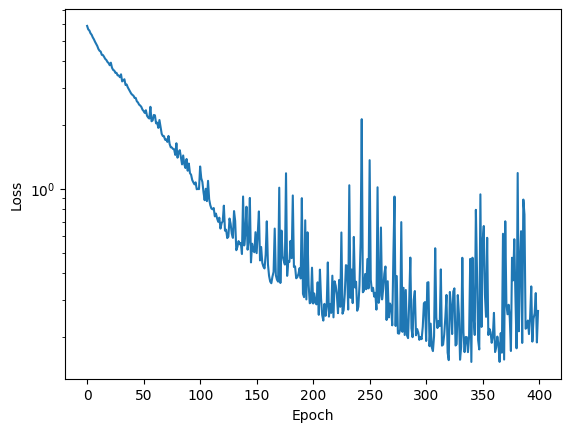

In [7]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [8]:
mask,Y = next(iter(dataloader))
mask = mask.to(device)
Y = Y.to(device)

In [9]:
x=mask.float().unsqueeze(-1)
x = x.permute(0, 4, 1, 2, 3)  # (N, D, H, W, C) → (N, C, D, H, W)
y = y.permute(0, 4, 1, 2, 3)
y_pred = model(x)
y_pred = y_pred.permute(0, 2, 3, 4, 1)  # (N, C, D, H, W) → (N, D, H, W, C)


In [10]:
y_pred.shape

torch.Size([100, 32, 16, 16, 5])

In [11]:
pred_sample = ds_voxel.prediction_to_sample(mask[0], y_pred[0])

In [12]:
pred_sample.plot("Pressure")

Widget(value='<iframe src="http://localhost:35183/index.html?ui=P_0x79e5e973e390_0&reconnect=auto" class="pyvi…

In [13]:
true_sample = ds_voxel.prediction_to_sample(mask[0], Y[0])
true_sample.plot("Pressure")

Widget(value='<iframe src="http://localhost:35183/index.html?ui=P_0x79e522c15310_1&reconnect=auto" class="pyvi…

In [14]:
true_sample.normalization

{'Pressure': [45.944515228271484, 46.475826263427734],
 'Temperature': [189.76951599121094, 140.30227661132812],
 'Velocity': [[3.3776817321777344, 0.008169999346137047, 0.04333029314875603],
  [3.001274347305298, 0.46628230810165405, 0.29493123292922974]],
 'Position': [[0.20000003278255463,
   -0.015664581209421158,
   0.00976521335542202],
  [0.11914395540952682, 0.03080119751393795, 0.006291054654866457]]}